<a href="https://colab.research.google.com/github/ramisa7/Deep-Learning/blob/main/Ramisa_12_Anomaly_detection_AE_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Anomaly detection with autoencoders

In this notebook we you have to create a fully-connected neural network based autoencoder in order to detect credit card frauds. In the dataset there are 492 labeled frauds and 284807 normal transactions. First, let's download the dataset and unpack it (original source of the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud - before downloading the data please read and accept the licence of the original datasource):

In [ ]:
!wget https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip

--2024-05-19 00:37:58--  https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip
Resolving www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)... 91.227.138.51
Connecting to www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)|91.227.138.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  20.1MB/s    in 3.3s    

2024-05-19 00:38:02 (20.1 MB/s) - ‘creditcardfraud.zip’ saved [69155632/69155632]



In [ ]:
%%capture
!unzip creditcardfraud.zip

## Imports
Import the necessary modules:

In [ ]:
import pandas as pd #
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
np.random.seed(123)

## Exercise 1: Reading and preparing the data
Read the creditcard.csv into a Pandas Dataframe with the [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [ ]:
df = pd.read_csv('creditcard.csv')

As the next step, select all the columns of the dataframe for the input X, but the "Class" column. And select the "Class" column for output Y. Make sure that both X and Y are two dimensional Numpy arrays.

Hint:
* you can use df.loc to select rows and columns from a dataframe
* you can get the Numpy array of a Pandas object with .values, eg. df['myfeature'].values

In [ ]:
X = df.loc[:, df.columns != 'Class'].values
Y = df.loc[:, 'Class'].values

In [ ]:
print("Shape of X:",X.shape)
print("Shape of Y:",Y.shape)

Shape of X: (284807, 30)
Shape of Y: (284807,)


Let's standardize the data:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Exercise 2: defining the autoencoder
Let's define a model according to the following instructions:
* the model's inputs and outputs should be the same as the number of X's features (columns)
* the model should have 5 hidden layers, with 16-10-6-10-16 neurons in the hidden layers, respectively
* all layers but the output should have tanh activation
* the output layer should have linear activation

In [ ]:
model = Sequential()

model.add(Dense(16, input_dim=X.shape[1], activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(X.shape[1], activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
 dense_3 (Dense)             (None, 10)                70        
                                                                 
 dense_4 (Dense)             (None, 16)                176       
                                                                 
 dense_5 (Dense)             (None, 30)                510       
                                                                 
Total params: 1488 (5.81 KB)
Trainable params: 1488 (5.8

## Exercise 3: define early stopping compile the model, and train it
Please pay attention to the following details:
* use EarlyStopping with patience 10 and this time monitor the training loss
* do not define validation data
* use mean squarred error loss function
* both the input and output of the model should be X this time. (as we are "auto encoding" the input to the output)

In [ ]:
patience = 10
es = EarlyStopping(monitor = 'loss', patience = patience)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history= model.fit(X, X, epochs=100, batch_size=256, shuffle=True, callbacks=[es])

Epoch 1/100
1113/1113 [==============================] - 8s 4ms/step - loss: 0.8060
Epoch 2/100
1113/1113 [==============================] - 4s 3ms/step - loss: 0.7481
Epoch 3/100
1113/1113 [==============================] - 5s 5ms/step - loss: 0.6734
Epoch 4/100
1113/1113 [==============================] - 4s 3ms/step - loss: 0.6400
Epoch 5/100
1113/1113 [==============================] - 4s 3ms/step - loss: 0.6260
Epoch 6/100
1113/1113 [==============================] - 5s 4ms/step - loss: 0.6155
Epoch 7/100
1113/1113 [==============================] - 4s 4ms/step - loss: 0.6055
Epoch 8/100
1113/1113 [==============================] - 4s 3ms/step - loss: 0.5939
Epoch 9/100
1113/1113 [==============================] - 4s 3ms/step - loss: 0.5804
Epoch 10/100
1113/1113 [==============================] - 5s 4ms/step - loss: 0.5694
Epoch 11/100
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5605
Epoch 12/100
1113/1113 [==============================] - 4s 3ms/step - lo

## Results analysis
After training is done, we make predictions for the complete dataset and inspect the reconstruction loss. Our assumption is that, higher reconstruction loss are more likely to belong to anomalies than lower reconstruciton loss.

In [ ]:
preds = model.predict(X)
errs  = np.square(preds-X)
errs  = np.mean(errs,axis=1)

8901/8901 [==============================] - 21s 2ms/step


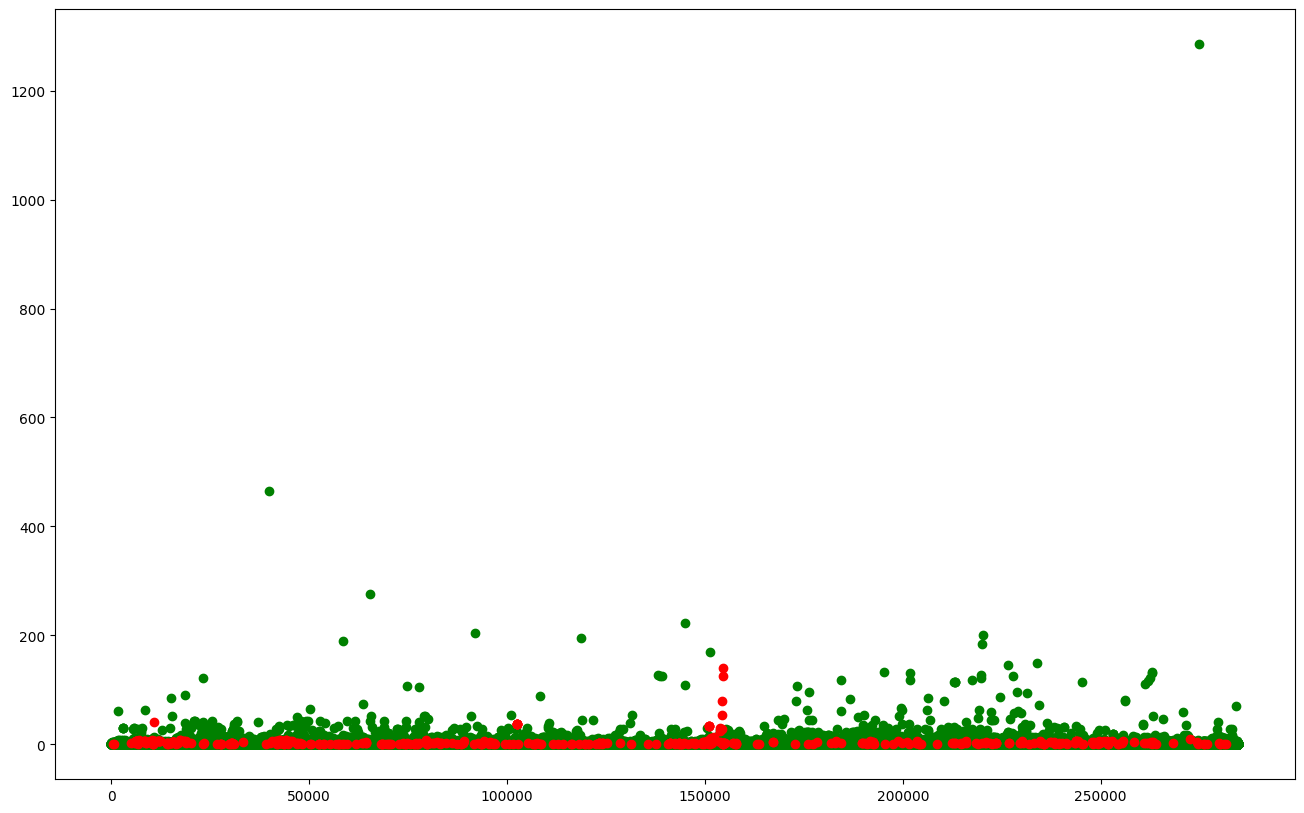

In [ ]:
plt.figure(figsize=(16,10))
rng = np.arange(len(errs))
colors = ['g','r'] # green: normal, red: anomaly
for i in [0,1]:
    plt.scatter(rng[(Y==i).reshape(-1)], errs[(Y==i).reshape(-1)], color=colors[i])

In [ ]:
Y_cut    = Y[errs<10]
errs_cut = errs[errs<10]

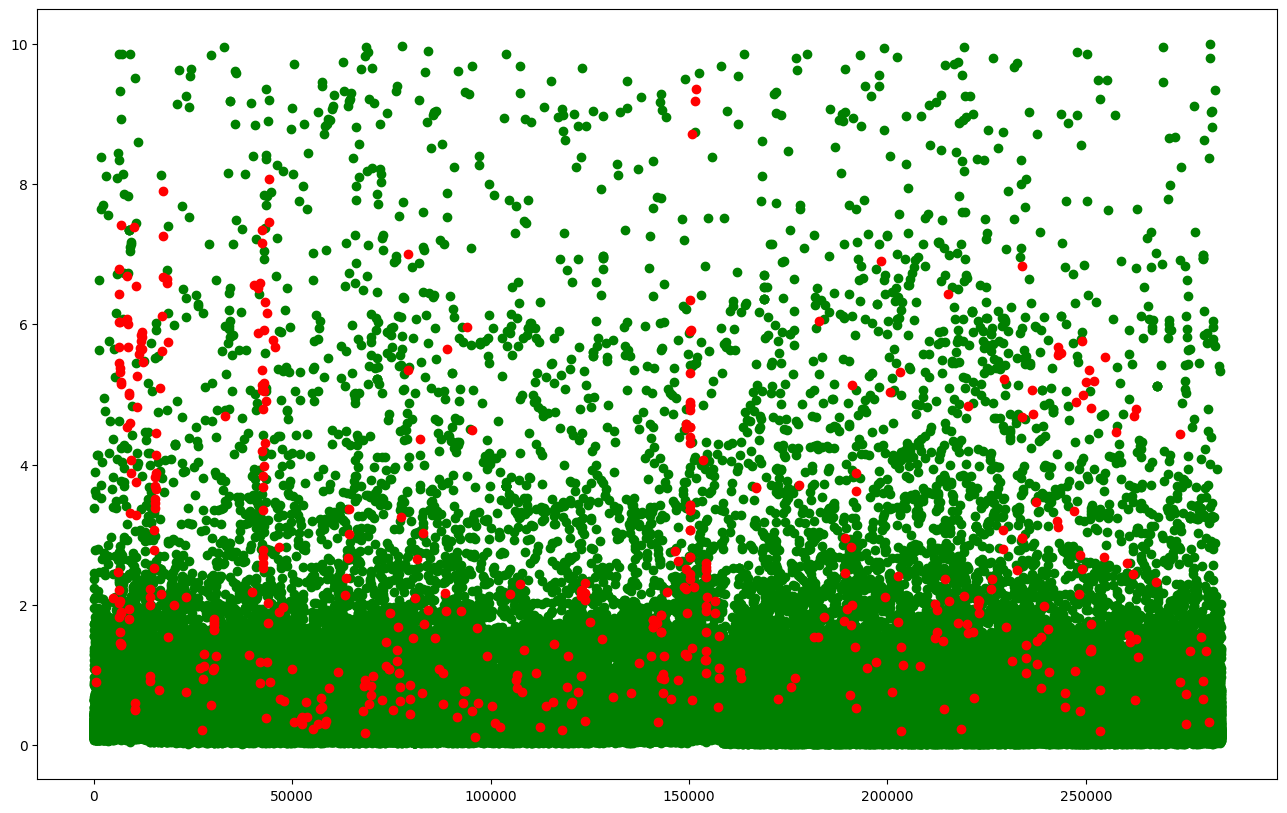

In [ ]:
plt.figure(figsize=(16,10))
rng = np.arange(len(errs_cut))
colors = ['g','r']
for i in [0,1]:
    plt.scatter(rng[(Y_cut==i).reshape(-1)], errs_cut[(Y_cut==i).reshape(-1)], color=colors[i])

## Exercise 4: finding the right treshold
Find a treshold that identifies at least 130 anomalies correctly with as small number of missclassifications of non-anomalies as possible.

In [ ]:
best_threshold = 0.0
best_fp_rate = float('inf')
best_tp = 0

for threshold in np.arange(0.0, 10.0, 0.1):
    errs_filtered = errs[errs > threshold]
    Y_filtered = Y[errs > threshold]
    errs_filtered_non_anomalies = errs[errs <= threshold]
    Y_filtered_non_anomalies = Y[errs <= threshold]

    tp = len(errs_filtered[Y_filtered == 1])  # True Positives
    fp = len(errs_filtered[Y_filtered == 0])  # False Positives

    if tp >= 130 and fp < best_fp_rate:
        best_threshold = threshold
        best_fp_rate = fp
        best_tp = tp

# Output the best threshold
print(f"Best Threshold: {best_threshold}")
print("Anomalies in the dataset")
print("   predicted as anomaly:", best_tp)
print("Non-anomalies in the dataset")
print("   predicted as anomaly:", best_fp_rate)




Best Threshold: 4.5
Anomalies in the dataset
   predicted as anomaly: 131
Non-anomalies in the dataset
   predicted as anomaly: 1857


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Initialize variables to track the best threshold and its metrics
best_threshold = 4.5
best_fp_rate = float('inf')
best_tp = 0
best_precision = 0
best_recall = 0
best_f1 = 0

# Define the range and step size for threshold tuning
thresholds = np.arange(4.0, 5.0, 0.1)

for threshold in thresholds:
    # Filter errors based on the threshold
    errs_filtered = errs[errs > threshold]
    Y_filtered = Y[errs > threshold]
    errs_filtered_non_anomalies = errs[errs <= threshold]
    Y_filtered_non_anomalies = Y[errs <= threshold]

    # Calculate true positives, false positives, true negatives, false negatives
    tp = len(errs_filtered[Y_filtered == 1])  # True Positives
    fp = len(errs_filtered[Y_filtered == 0])  # False Positives
    tn = len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 0])  # True Negatives
    fn = len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 1])  # False Negatives

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print results for the current threshold
    print(f"Threshold: {threshold}")
    print("Anomalies in the dataset")
    print(f"   predicted as anomaly: {tp}")
    print(f"   predicted as non-anomaly: {fn}")
    print("Non-anomalies in the dataset")
    print(f"   predicted as anomaly: {fp}")
    print(f"   predicted as non-anomaly: {tn}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print()

    # Update the best threshold based on a chosen criterion (e.g., best F1 score)
    if tp >= 130 and f1 > best_f1:
        best_threshold = threshold
        best_fp_rate = fp
        best_tp = tp
        best_precision = precision
        best_recall = recall
        best_f1 = f1

# Output the best threshold and its metrics
print(f"Best Threshold: {best_threshold}")
print("Anomalies in the dataset")
print(f"   predicted as anomaly: {best_tp}")
print(f"   predicted as non-anomaly: {361 - best_tp}")
print("Non-anomalies in the dataset")
print(f"   predicted as anomaly: {best_fp_rate}")
print(f"   predicted as non-anomaly: {284807 - best_fp_rate}")
print(f"Best Precision: {best_precision:.4f}, Best Recall: {best_recall:.4f}, Best F1 Score: {best_f1:.4f}")


Threshold: 4.0
Anomalies in the dataset
   predicted as anomaly: 143
   predicted as non-anomaly: 349
Non-anomalies in the dataset
   predicted as anomaly: 2102
   predicted as non-anomaly: 282213
Precision: 0.0637, Recall: 0.2907, F1 Score: 0.1045

Threshold: 4.1
Anomalies in the dataset
   predicted as anomaly: 141
   predicted as non-anomaly: 351
Non-anomalies in the dataset
   predicted as anomaly: 2058
   predicted as non-anomaly: 282257
Precision: 0.0641, Recall: 0.2866, F1 Score: 0.1048

Threshold: 4.199999999999999
Anomalies in the dataset
   predicted as anomaly: 139
   predicted as non-anomaly: 353
Non-anomalies in the dataset
   predicted as anomaly: 1991
   predicted as non-anomaly: 282324
Precision: 0.0653, Recall: 0.2825, F1 Score: 0.1060

Threshold: 4.299999999999999
Anomalies in the dataset
   predicted as anomaly: 139
   predicted as non-anomaly: 353
Non-anomalies in the dataset
   predicted as anomaly: 1938
   predicted as non-anomaly: 282377
Precision: 0.0669, Recall

We can also inspect the confusion matrix:

Anomalies in the dataset
   predicted as anomaly: 139
   predicted as non-anomaly: 353
Non-anomalies in the dataset
   predicted as anomaly: 1938
   predicted as non-anomaly: 282377


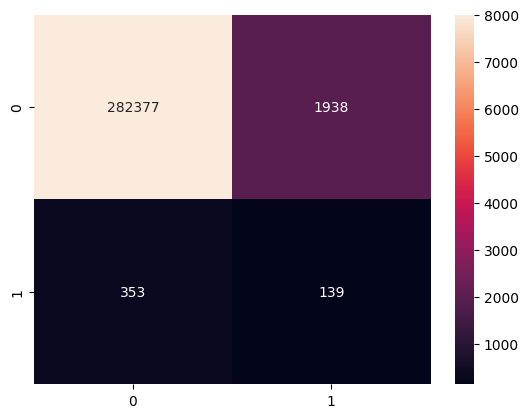

In [ ]:
# Final filtering and confusion matrix
errs_filtered = errs[errs > best_threshold]
Y_filtered = Y[errs > best_threshold]
errs_filtered_non_anomalies = errs[errs <= best_threshold]
Y_filtered_non_anomalies = Y[errs <= best_threshold]

print("Anomalies in the dataset")
print("   predicted as anomaly:", len(errs_filtered[Y_filtered == 1]))
print("   predicted as non-anomaly:", len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 1]))
print("Non-anomalies in the dataset")
print("   predicted as anomaly:", len(errs_filtered[Y_filtered == 0]))
print("   predicted as non-anomaly:", len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 0]))

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(Y, errs > best_threshold)
sns.heatmap(conf, annot=True, vmax=8000, fmt="d")
plt.show()